This notebook describes processing of exonic coordinates from a GTF annotation file, processing of sites from the archaic admixture array and generation of recombination map for SLiM simulations.

In [1]:
from pybedtools import BedTool
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.style.use('ggplot')

## Exon coordinates processing

First download the GTF annotations:

In [3]:
gtf = pd.read_table('ftp://ftp.ensembl.org/pub/release-75/gtf/homo_sapiens/Homo_sapiens.GRCh37.75.gtf.gz',
                    header=None, sep='\t', skipinitialspace=True, skiprows=5, compression='gzip',
                    names=['chrom', 'source', 'feature', 'start', 'end',
                           'score', 'strand', 'frame', 'attribute'], low_memory=False)

What does the data look like?

In [4]:
gtf.head()

,chrom,source,feature,start,end,score,strand,frame,attribute
0,1,pseudogene,gene,11869,14412,.,+,.,"gene_id ""ENSG00000223972""; gene_name ""DDX11L1""..."
1,1,processed_transcript,transcript,11869,14409,.,+,.,"gene_id ""ENSG00000223972""; transcript_id ""ENST..."
2,1,processed_transcript,exon,11869,12227,.,+,.,"gene_id ""ENSG00000223972""; transcript_id ""ENST..."
3,1,processed_transcript,exon,12613,12721,.,+,.,"gene_id ""ENSG00000223972""; transcript_id ""ENST..."
4,1,processed_transcript,exon,13221,14409,.,+,.,"gene_id ""ENSG00000223972""; transcript_id ""ENST..."


In [5]:
gtf.source.value_counts()

protein_coding                        2001054
nonsense_mediated_decay                293471
processed_transcript                   173401
retained_intron                        150034
lincRNA                                 55928
antisense                               45811
processed_pseudogene                    24517
pseudogene                              17830
unprocessed_pseudogene                  13763
miRNA                                   10209
transcribed_unprocessed_pseudogene       7931
misc_RNA                                 6554
snRNA                                    6215
snoRNA                                   4791
sense_intronic                           3241
polymorphic_pseudogene                   1906
rRNA                                     1706
unitary_pseudogene                       1467
sense_overlapping                        1463
IG_V_gene                                1277
transcribed_processed_pseudogene         1182
non_stop_decay                    

In [6]:
gtf.feature.value_counts()

exon              1306656
CDS                791856
UTR                304070
transcript         215170
stop_codon          73411
start_codon         73358
gene                63677
Selenocysteine        114
Name: feature, dtype: int64

Take only autosomal protein-coding regions, since we won't be simulating sex chromosomes:

In [7]:
AUTOSOMES = [str(i + 1) for i in range(22)]

In [8]:
exons = gtf[gtf.chrom.isin(AUTOSOMES) &
           (gtf.source == "protein_coding") &
           (gtf.feature == "exon")]

Merge the overlapping exons:

In [9]:
exons = BedTool.from_dataframe(exons).sort().merge().to_dataframe()

In [10]:
exons['type'] = 'exon'

Convert chromosome IDs to integers and sort coordinates:

In [11]:
exons.chrom = exons.chrom.astype(int)
exons.sort_values(by=['chrom', 'start'], inplace=True)

What is the distribution of exon lengths?

In [12]:
((exons.end - exons.start)).describe()

count    214193.000000
mean        337.708039
std         776.506070
min           1.000000
25%          96.000000
50%         138.000000
75%         217.000000
max       24409.000000
dtype: float64

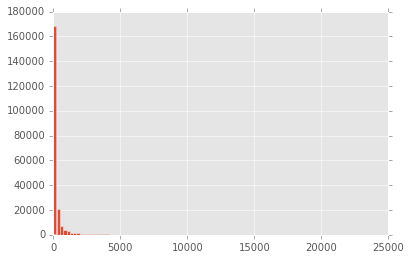

In [13]:
plt.figure_ = plt.hist((exons.end - exons.start), bins=100)

In [14]:
exons.head()

,chrom,start,end,type
0,1,69090,70008,exon
1,1,134900,135802,exon
2,1,137620,139379,exon
3,1,367639,368634,exon
4,1,621058,622053,exon


## Process positions from the archaic admixture array

Load the coordinates of sites from the archaic admixture array:

In [15]:
array_sites = pd.read_table('../raw_data/ice_age/filter.gz', names=['chrom', 'end', 'set_1', 'set_2'])

Subset to sites in the so called "Set 1" (see `raw_data/ice_age/README.md` for more information):

In [16]:
array_sites = array_sites[array_sites.set_1 == 1]

Convert the table into a BED format:

In [17]:
array_sites['start'] = array_sites.end - 1
array_sites = array_sites[['chrom', 'start', 'end']]

In [18]:
array_sites['type'] = 'snp'

In [19]:
array_sites.head()

,chrom,start,end,type
0,1,847982,847983,snp
1,1,853088,853089,snp
2,1,853595,853596,snp
3,1,854792,854793,snp
5,1,867150,867151,snp


## Create a union of exon regions with admixture array informative positions

Take the subset of array sites that lie outside exons:

In [20]:
exome = BedTool.from_dataframe(exons)
sites_outside_exons = BedTool.from_dataframe(array_sites).intersect(exome, v=True).to_dataframe().rename(columns={'name': 'type'})

Merge the tables with coordinates of exons and sites outside exons:

In [21]:
exons_and_sites = pd.concat([sites_outside_exons,
                             exons]).sort_values(by=['chrom', 'start']).reset_index(drop=True)

In [22]:
exons_and_sites.head()

,chrom,start,end,type
0,1,69090,70008,exon
1,1,134900,135802,exon
2,1,137620,139379,exon
3,1,367639,368634,exon
4,1,621058,622053,exon


In [23]:
len(exons_and_sites)

978902

### Add 1 bp "gaps" with recombination rate 0.5 after last exon/site on each chromosome

This will simulate random segregation between chromosomes.

In [24]:
# get the coordinates of last exons/sites on each chromosome
last_rows = pd.concat(exons_and_sites.query('chrom == ' + str(chrom)).tail(1)
                      for chrom in AUTOSOMES)

# generate coordinates of 1 bp recombination gaps between chromosomes
# by placing a new 1bp region after last exon/site on each chromosome
# (but no recombination gap after the very last chromosome)
recomb_gaps = pd.DataFrame({'chrom': last_rows.chrom,
                            'start': last_rows.end,
                            'end'  : last_rows.end + 1,
                            'type' : 'gap'},
                            columns=['chrom', 'start', 'end', 'type'])[:-1]

# merge the recombination gaps with exons/sites coordinates
exons_and_sites = pd.concat([exons_and_sites,
                             recomb_gaps]).sort_values(by=['chrom', 'start']).reset_index(drop=True)

Total size of the table  should increase by 21.

In [25]:
len(exons_and_sites)

978923

### Convert chromosome-based coordinates into SLiM single-segment coordinates

SLiM simulates everything as a single segment. We want to concatenate all chromosome into a single chromosome, shifting coordinates of all regions (exons, snps and recombination gaps) appropriately.

In [26]:
# value by which we have to increment all coordinates on
# next chromosome
increment_by = 0

for chrom in AUTOSOMES:
    # get DataFrame indices of exons/sites on a current chromosome
    coords_on_chrom = exons_and_sites.chrom == int(chrom)
    
    # get start/end coordinates of these exons/sites
    start_coords = exons_and_sites.ix[coords_on_chrom, 'start']
    end_coords   = exons_and_sites.ix[coords_on_chrom, 'end']
    
    # shift the coordinates appropriately
    exons_and_sites.ix[coords_on_chrom, 'slim_start'] = start_coords + increment_by
    exons_and_sites.ix[coords_on_chrom, 'slim_end']   = end_coords + increment_by
    
    increment_by = max(end_coords + increment_by)

# convert to integer types
exons_and_sites[['slim_start', 'slim_end']] = exons_and_sites[['slim_start', 'slim_end']].astype(int)

Coordinates in SLiM are 0-based - we have to subtract 1 from the end coordinates, because these are normally 1-based (as required by the BED format).

In [27]:
exons_and_sites.slim_end -= 1

In [28]:
exons_and_sites.tail()

,chrom,start,end,type,slim_start,slim_end
978918,22,51215097,51215177,exon,2877427107,2877427186
978919,22,51216379,51216409,exon,2877428389,2877428418
978920,22,51220615,51220779,exon,2877432625,2877432788
978921,22,51221196,51221714,exon,2877433206,2877433723
978922,22,51221928,51222091,exon,2877433938,2877434100


## Save SLiM coordinates of all sites from the archaic admixture array

The map of sites and exons includes only positions of sites that fall outside of exonic regions. However, in order to simulate all the sites from the archaic admixture array, we have to know the positions of sites _within_ exons too.

To obtain the coordinates of array sites within exons, we need to find out (for each site) which exon does it fall in and calculate its position relative to the start of that exon.

Take the subset of array sites that lie inside exons:

In [29]:
sites_within_exons = BedTool.from_dataframe(array_sites).intersect(exome).to_dataframe()

In [30]:
sites_within_exons = sites_within_exons.rename(columns={'name': 'type'})

Get a DataFrame of the coordinates of exons that contain a site from the admixture array (will contain multiple copies of one exon if more than one site falls within that exon):

In [31]:
exons_with_sites = BedTool.from_dataframe(exons_and_sites.query('type == "exon"')).intersect(BedTool.from_dataframe(sites_within_exons), wa=True).to_dataframe()

exons_with_sites = exons_with_sites.rename(columns={'score': 'slim_start', 'strand': 'slim_end'})

Calculate the position of each site relative to the start of "its" exon:

In [32]:
increments = sites_within_exons.start - exons_with_sites.start

sites_within_exons['slim_start'] = exons_with_sites.slim_start + increments
sites_within_exons['slim_end']   = exons_with_sites.slim_start + increments

Merge the coordinates of SNPs within and outside exons:

In [33]:
all_sites = pd.concat([exons_and_sites.query('type == "snp"'),
                       sites_within_exons]).sort_values(by=['slim_start']).reset_index(drop=True)

Verify that we didn't loose any sites during all this coordinate acrobatics:

In [34]:
len(array_sites) == len(all_sites)

True

Output the SLiM-based positions of informative sites:

In [35]:
all_sites['slim_start'].to_csv('../slim/admixture_array_sites.txt', index=False)

## Save SLiM coordinates of exonic regions only

This is required for specification for the `initializeGenomicElement` function in SLiM.

In [36]:
exons_and_sites.query('type == "exon"')[['slim_start', 'slim_end']].to_csv('../slim/exons.txt',
                                                                           sep='\t', header=False, index=False)

## Save the recombination map for SLiM
This recombination map will be provided as an argument for the `initializeRecombinationRate` function in SLiM.

The recombination map will specify the genome-wide average recombination rate values for the chromosomal parts of the simulated segment and 0.5 recombination rate for 1bp "gaps" between chromosomes.

In [37]:
RECOMB_RATE = 1e-8 # crossovers per bp per generation

In [38]:
gap_map = exons_and_sites.query('type == "gap"')[['type', 'slim_end']]
gap_map['recomb_rate'] = 0.5

In [39]:
chrom_map = pd.DataFrame({'type': 'chromosome',
                          'slim_end': list(gap_map.slim_end - 1) + [max(exons_and_sites.slim_end)],
                          'recomb_rate': RECOMB_RATE},
                         columns=['type', 'slim_end', 'recomb_rate'])

In [40]:
recomb_map = pd.concat([gap_map, chrom_map]).sort_values(by='slim_end').reset_index(drop=True)

In [42]:
recomb_map

,type,slim_end,recomb_rate
0,chromosome,249214144,1.000000e-08
1,gap,249214145,5.000000e-01
2,chromosome,492058847,1.000000e-08
3,gap,492058848,5.000000e-01
4,chromosome,689829439,1.000000e-08
5,gap,689829440,5.000000e-01
6,chromosome,880843159,1.000000e-08
7,gap,880843160,5.000000e-01
8,chromosome,1061638423,1.000000e-08
9,gap,1061638424,5.000000e-01


In [43]:
recomb_map[['slim_end', 'recomb_rate']].to_csv('../slim/recombination_map.txt', sep='\t', index=False)